## Improvements to Mapping Traffic Collsions

In [1]:
# import libraries
import pandas as pd
import geopandas as gpd

# to give more power to your figures (plots)
import matplotlib.pyplot as plt

import contextily as ctx

# for interactive plots, similar to geopands (your choice between folium vs plotly)
import plotly.express as px

# to import open data - in order to use the API links in some of the gov websites
from sodapy import Socrata

import requests

In [2]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

# Specify the year you want to retrieve
year = 2020

# Construct SoQL query to filter data by date range for the specified year
query = f"SELECT * WHERE date_occ >= '{2020}-01-01T00:00:00.000' AND date_occ < '{2020 + 1}-01-01T00:00:00.000'"


# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy. 250,000 would take a long time to upload/be slow
results = client.get("d5tf-ez2w", query = query)

# Convert to pandas DataFrame containing 2020 collisions data
df = pd.DataFrame.from_records(results)

In [3]:
#Using CSV in order to increase data input to 43k, instead of API limit of 1000. 
tcd = pd.read_csv('la_collisions_overview_leila/Traffic_Collisions_2020-Copy1.csv')

In [4]:
#lets fix the spaces in the variable names, because it drives us nuts later! 
tcd.rename(columns={'old column name with spaces': 'new_column_name',
                    'Victim Age' : 'victim_age',
                    'Victim Sex' : 'victim_sex',
                    'Victim Descent' : 'victim_descent'
                   }, inplace=True)
tcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42382 entries, 0 to 42381
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DR Number               42382 non-null  int64  
 1   Date Reported           42382 non-null  object 
 2   Date Occurred           42382 non-null  object 
 3   Time Occurred           42382 non-null  int64  
 4   Area ID                 42382 non-null  int64  
 5   Area Name               42382 non-null  object 
 6   Reporting District      42382 non-null  int64  
 7   Crime Code              42382 non-null  int64  
 8   Crime Code Description  42382 non-null  object 
 9   MO Codes                40409 non-null  object 
 10  victim_age              39712 non-null  float64
 11  victim_sex              41475 non-null  object 
 12  victim_descent          41419 non-null  object 
 13  Premise Code            41540 non-null  float64
 14  Premise Description     41539 non-null

In [5]:
# convert df to gdf
# since data is in lat/lon's assign the crs to WGS84 (epsg:4326)
gtcd = gpd.GeoDataFrame(tcd, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(tcd.Longitude, tcd.Latitude))
gtcd.head(2)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,victim_age,victim_sex,victim_descent,Premise Code,Premise Description,Address,Cross Street,Latitude,Longitude,geometry
0,200113538,6/17/2020,6/14/2020,2030,1,Central,195,997,TRAFFIC COLLISION,0605 3101 3401 3701 3006 3030 1501,31.0,F,H,101.0,STREET,15TH,MAPLE,34.0326,-118.2589,POINT (-118.25890 34.03260)
1,200518005,12/19/2020,12/19/2020,2205,5,Harbor,514,997,TRAFFIC COLLISION,3036 3004 3026 3029 3101,39.0,F,H,101.0,STREET,LOMITA,FIGUEROA,33.7982,-118.2830,POINT (-118.28300 33.79820)


In [6]:
#calculate the bounding box we're starting with
gtcd.drop(gtcd.loc[gtcd.Latitude==0].index,axis=0,inplace=True)

bbox = gtcd.total_bounds

#print the bounding box
print("Bounding Box:")
print("min Longitude:", bbox[0])
print("min Latitude:", bbox[1])
print("max Longitude:", bbox[2])
print("max Latitude:", bbox[3])

axis = bbox

Bounding Box:
min Longitude: -118.6663
min Latitude: 33.7065
max Longitude: -118.1554
max Latitude: 34.3343


In [7]:
tracts = gpd.read_file('Data/Census_Tracts_2020.geojson')

In [8]:
tractpoly = tracts.geometry.tolist()


In [9]:
gtcd.clip(axis)


,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,victim_age,victim_sex,victim_descent,Premise Code,Premise Description,Address,Cross Street,Latitude,Longitude,geometry
6771,200515686,10/23/2020,10/23/2020,310,5,Harbor,584,997,TRAFFIC COLLISION,3037 3006 3028 3030 3101,68.0,M,H,101.0,STREET,PASEO DEL MAR,GAFFEY ST,33.7065,-118.2929,POINT (-118.29290 33.70650)
13856,200511103,6/27/2020,6/27/2020,130,5,Harbor,587,997,TRAFFIC COLLISION,3037 3011 3028 3030 3101,19.0,M,O,101.0,STREET,PASEO DEL MAR,GAFFEY ST,33.7065,-118.2929,POINT (-118.29290 33.70650)
7075,200509078,4/30/2020,4/30/2020,30,5,Harbor,584,997,TRAFFIC COLLISION,3037 3011 3034 3026 3101,NaN,X,X,101.0,STREET,800 S PASEO DEL MAR,NaN,33.7070,-118.2939,POINT (-118.29390 33.70700)
38956,200515423,10/18/2020,10/18/2020,800,5,Harbor,587,997,TRAFFIC COLLISION,3037 3006 3028 3030 3101,23.0,M,O,101.0,STREET,GAFFEY ST,40TH ST,33.7079,-118.2929,POINT (-118.29290 33.70790)
22687,200511639,7/9/2020,7/9/2020,1730,5,Harbor,584,997,TRAFFIC COLLISION,3036 3004 3028 3030 3101,30.0,M,H,101.0,STREET,LEAVENWORTH,GAFFEY,33.7113,-118.2929,POINT (-118.29290 33.71130)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41284,201917939,12/10/2020,12/10/2020,1735,19,Mission,1906,997,TRAFFIC COLLISION,3039 3011 3037 3028 3101 4019,40.0,M,H,101.0,STREET,BRUSSELS AV,ORO GRANDE ST,34.3221,-118.4283,POINT (-118.42830 34.32210)
18637,201907860,3/19/2020,3/19/2020,1230,19,Mission,1904,997,TRAFFIC COLLISION,3006 3028 3030 3037 3101 4026,36.0,M,O,NaN,NaN,00,NaN,34.3235,-118.4318,POINT (-118.43180 34.32350)
22798,201911740,7/5/2020,7/4/2020,2050,19,Mission,1906,997,TRAFFIC COLLISION,4026 3024 3036 3101 3012,26.0,M,H,101.0,STREET,EGBERT ST,LEXICON AV,34.3255,-118.4285,POINT (-118.42850 34.32550)
20825,201913769,8/26/2020,8/25/2020,2330,19,Mission,1906,997,TRAFFIC COLLISION,3037 3025 3101 4026 3012,NaN,M,W,101.0,STREET,CLAYWOOD AV,BADGER AV,34.3266,-118.4269,POINT (-118.42690 34.32660)


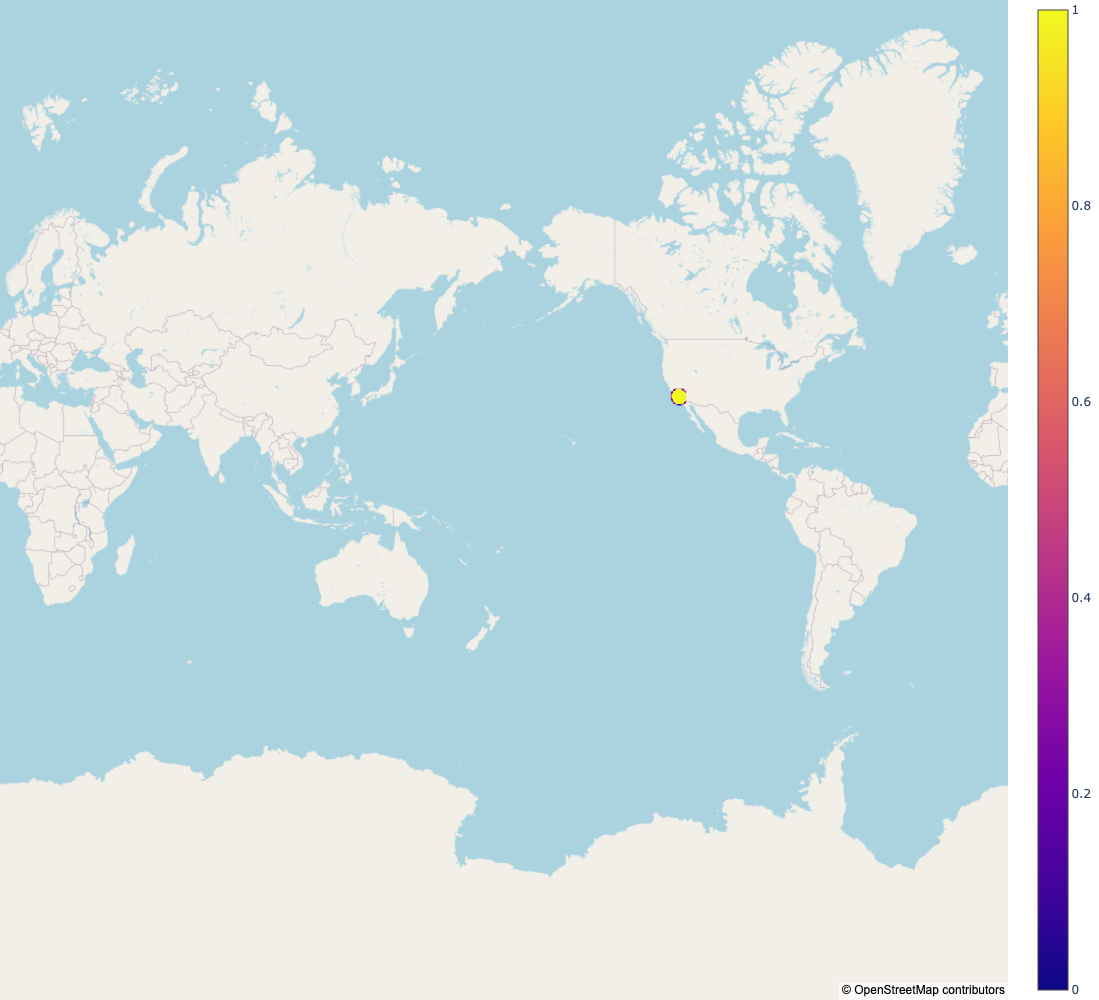

In [15]:
import plotly.graph_objects as go
fig = go.Figure(go.Densitymapbox(lat=gtcd.Latitude, lon=gtcd.Longitude,
                                 radius=5))
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.update_xaxes(range=[bbox[0], bbox[2]])
fig.update_yaxes(range=[bbox[1], bbox[3]])  
fig.show()

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import plotly.express as px
from sodapy import Socrata
import requests

In [12]:
##2010 Traffic Collisions in LA County

In [13]:
gdf = gpd.read_file('2010_.csv')

ERROR:fiona._env:2010_.csv: No such file or directory


DriverError: 2010_.csv: No such file or directory

In [ ]:
gdf['lat']=gdf['Location'].str.extract(r'\((.*),.*\)')
gdf['long']=gdf['Location'].str.extract(r'\(.*,(.*)\)')
gdf.head()

In [ ]:
gdf = gpd.GeoDataFrame(gdf, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(gdf.long, gdf.lat))

In [ ]:
gdf.crs

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

ax = gdf.clip([-189,18,-66,71]).plot(ax=ax, 
        marker='X',
        markersize=10,
        color='blue')

ax.axis('off')

ax.set_title('Traffic Collisions 2010')

ctx.add_basemap(ax, crs=4326)

In [ ]:
gdf.info()

In [ ]:
import pandas as pd

# Assuming you have a DataFrame named 'df' with a 'Victim Age' column

# Convert 'Victim Age' column to numeric, coerce errors to NaN for non-numeric values
gdf['Victim Age'] = pd.to_numeric(gdf['Victim Age'], errors='coerce')

# Drop rows with NaN values in the 'Victim Age' column
gdf = gdf.dropna(subset=['Victim Age'])

# Now 'Victim Age' should contain only numeric values

# Create a new column 'age_by_cat' to store the categories
gdf['age_by_cat'] = pd.cut(gdf['Victim Age'], bins=[0, 18, 25, 35, 45, float('inf')], labels=['under 18', '18-25', '26-35', '36-45', '45+'], right=False, include_lowest=True)

# Plotting
gdf['age_by_cat'].value_counts().sort_index().plot(kind='bar', rot=0)
plt.title('Distribution of Victim Age Categories')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.show()


In [ ]:
age_cat = []
for age in gdf['Victim Age']: 
    if pd.isnull(age):  # Check if age is missing
        age_cat.append('NaN')  # Append 'Missing' category
        #missing_count += 1  # Increment missing count
    elif age < 18: 
        age_cat.append('under 18')
    elif 18 <= age <= 24: 
        age_cat.append('18-24')
    elif 25 <= age <= 34:
        age_cat.append('25-34')
    elif 35 <= age <= 44:
        age_cat.append('35-44')
    elif 45 <= age <= 54: 
        age_cat.append('45-54')
    elif 55 <= age <= 64:
        age_cat.append('55-64')
    elif age >= 65:
        age_cat.append('65+')
# add this new variable to the dataframe next
gdf['Victim Age'] = age_cat

#check to see if added to data frame correctly
gdf.head(2)

In [ ]:
gdf.age_by_cat.count()

In [ ]:
gdf['Victim Age'].plot.bar(x='age_by_cat',
                        y='count',
                  title='LA Traffic collisions sorted by Victim Age')

In [ ]:
race = getattr(gdf,'Victim Descent').unique().tolist()
print(race)

In [ ]:
fig = px.bar(
        gpd,
        x='Victim Descent',
        title='LA Traffic Collisions sorted by Victim Descent, 2020',
        color='red',
        labels={ 
            'A' : 'Other Asian',
            'B' : 'Black',
            'C' : 'Chinese',
            'D' : 'Cambodian',
            'F' : 'Filipino',
            'G' : 'Guamanian',
            'H' : 'Hispanic/ Latin/ Mexican',
            'I' : 'American Indian/ Alaskan Native',
            'J' : 'Japanese',
            'K' : 'Korean',
            'L' : 'Laotian',
            'O' : 'Other',
            'P' : 'Pacific Islander',
            'S' : 'Samoan',
            'U' : 'Hawaiian',
            'V' : 'Vietnamese',
            'W' : 'White',
            'X' : 'Unknown',
            'Z' : 'Asian Indian'  
        }
)
# get rid of white lines inside the bars
fig.update_traces(marker_line_width=0)

# Update observation labels
fig.update_traces(text=['Other Asian', 'Black', 'Chinese'], textposition='outside')

# show the figure
fig.show()

In [ ]:
Area = ["West LA","Hollywood", "Compton"]

In [ ]:

for city in Area:

  
    fig, ax = plt.subplots(figsize=(8,8))

    gdf[gdf['Area Name'] == city].plot(ax=ax, 
                          marker='X',
                          markersize=50,
                          color='red')

    ax.axis('off')
  
    ax.set_title('Fatal police shootings in '+str(city) + ' since 2015')

    ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=4326)

In [ ]:
gdf

In [ ]:

gdf = gpd.GeoDataFrame(
    arrests_mini, geometry=gpd.points_from_xy(arrests_mini.lon, arrests_mini.lat),crs=4326)


gdf.plot()


In [ ]:
#Importing 2020 crash data 

In [ ]:
gdf2 = gpd.read_file('2020.csv')

In [ ]:
gdf2['lat']=gdf2['Location'].str.extract(r'\((.*),.*\)')
gdf2['long']=gdf2['Location'].str.extract(r'\(.*,(.*)\)')
gdf2.head()

In [ ]:
gdf2 = gpd.GeoDataFrame(gdf2, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(gdf2.long, gdf2.lat))

In [ ]:
gdf2 = gpd.GeoDataFrame(gdf, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(gdf2.long, gdf2.lat))

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

ax = gdf2.clip([-189,18,-66,71]).plot(ax=ax, 
        marker='X',
        markersize=10,
        color='blue')

ax.axis('off')

ax.set_title('Traffic Collisions 2020')


ctx.add_basemap(ax, crs=4326)